<a href="https://colab.research.google.com/github/Dagobert42/langID-NLP/blob/master/langID_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Preparation
This subsection contains methods to produce uniformly distributed chunks of our data set. From these we can then obtain n-grams of different sizes. The Wikipedia Language Identification database contains txt-files of x_train and x_test for example sentences and accordingly ordered labels in y_train, y_test.
We read these examples and cluster them by their respective language label.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import ngrams
import collections
from collections import defaultdict
from collections import Counter

In [ ]:
!npx degit Dagobert42/langID-NLP/WiLI-2018_data -f

npx: installed 1 in 1.522s
> destination directory is not empty. Using --force, continuing
> cloned Dagobert42/langID-NLP#master


In [4]:
# read data
# written for the WiLI-2018 data set: https://zenodo.org/record/841984
# make sure txt-files are in the specified directory when running this
X_train = open('/content/drive/MyDrive/Colab Notebooks/x_train.txt', encoding="utf8").read().split('\n')
Y_train = open('/content/drive/MyDrive/Colab Notebooks/y_train.txt', encoding="utf8").read().split('\n')
X_test = open('/content/drive/MyDrive/Colab Notebooks/x_test.txt', encoding="utf8").read().split('\n')
Y_test = open('/content/drive/MyDrive/Colab Notebooks/y_test.txt', encoding="utf8").read().split('\n')
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/labels.csv', delimiter = ';')

In [7]:
# preprocessing the data

def preprocess(X,Y):

  # convert language labels to language Name => 'en' -> 'English'
  lab_dict = { labels.loc[i]['Label'] : labels.loc[i]['English'] for i in range(0, len(labels)) }
  y_train = [ lab_dict[item] if item != 'nan' else 'Min Nan Chinese' for item in Y ]

  # remove unnecessary characters from data
  extras = '!"$%&/{}[]()=?\\`´*+~#-_.:,;<>|1234567890°-\'' # Characters to remove from data
  rx = '[' + re.escape(''.join(extras)) + ']'
  x_train = [] 
  to_remove = []
  i = 0
  for example in X:
      processed = re.sub(' +', ' ', re.sub(rx, '', example))
      if(len("".join(processed.split()))): # Some examples after preprocessing only contain spaces, this is a check for those examples.
        x_train.append(processed)
      else:
        y_train.pop(i)
      i+=1

  return x_train,y_train

# x_train = [ex1,ex2,ex3,...]
# y_train = [lang_of_ex1,......]

In [8]:
# sort data by language
def data_by_lang(X, Y):
    lang_corpora = defaultdict(list)
    lang_idx = defaultdict(list)
    for i in range(len(X)):
        lang_corpora[Y[i]].append(X[i])
        lang_idx[Y[i]].append(i)

    return lang_corpora, lang_idx
# lang_corpora = { 'Lang1' : [ex1,ex2,...], 'Lang2' : [ex1, ex2,,...],...}
# land_idx = { 'Lang1' : [23,41,..index of example in Lang1..], 'Lang2' : [1,19,....],...}

In [30]:
# extract uniformly distributed list of examples from our data set
# takes an optional argument to constrain the list of languages
def get_data_chunk(X, Y, n_instances, lang_keys=[]):
    _, lang_idx = data_by_lang(X, Y)
    x_train = []
    y_train = []
    
    langs = set()
    if lang_keys: 
        langs = set(lang_keys)
    else:
        langs = set(Y)

    for lang in langs:
        indices = lang_idx[lang]
        for index in range(n_instances):
            x_train.append(X[indices[index]])
            y_train.append(Y[indices[index]])

    return x_train, y_train

# x_train [ lang1_ex,lang1_ex,..n_instance_of_lang1..,lang2_ex,lang2_ex,....,...]
# y_train [ lang1,lang1,....lang2,lang2,...]

In [31]:
# creating n-grams for each data entry
# optional arguments:
#    lang_keys - constrains the languages to use
#    stepsize  - specifies the amount of characters
#                to jump until the next n-gram
# returns a list of n-grams
#def make_n_grams(X, Y, n, stepsize=1, lang_keys=None):
def make_n_grams(X, Y, n, lang_keys=[], stepsize=1):
    assert stepsize >= 1
    x_to_grams = []

    langs = set()
    if lang_keys: 
        langs = set(lang_keys)
    else:
        langs = set(Y)

    for i in range(len(X)):
        if Y[i] in langs:
            sent = X[i]
            x_to_grams.append([sent[j:j+n] for j in range(0, len(sent) - n+1, stepsize)])

    return x_to_grams

# x_to_grams = [[ngram_in_ex1],[ngram_in_ex2],....]

In [32]:
# counting and sorting n-grams for each language
# returns a sorted dict of lang : {n-gram : count}
def sort_by_tf(X, Y):
    # calculating term frequency of n-grams per language
    tf_per_lang = defaultdict(list)
    langs = set(Y)
    data, _ = data_by_lang(X, Y)
    for lang,gram_list in data.items():
      data[lang] = [ gram for grams in gram_list for gram in grams] # Comvert list of lists to a single list
    for lang in langs:
        tf_per_lang[lang] = dict(
            zip(list(Counter(data[lang]).keys()),
                 list(Counter(data[lang]).values())))

    # sort by term frequency
    sorted_tf_per_lang = defaultdict(list)
    for lang in langs:
        sorted_tf_per_lang[lang] = { word : value for word, value in sorted(tf_per_lang[lang].items(), key=lambda item:item[1], reverse=True) }
    
    return sorted_tf_per_lang


### Understanding Data
In the following we review some examples to get an understanding of our data...
Particularly interesting are languages with a degree of similarity. Here we print examples of languages that use the latin alphabet.

In [33]:
import matplotlib
import matplotlib.pyplot as plt

def make_barplots(n_gram_size, lang_key, commoncollect, base_counts, compare_counts, otherlangs):
    width = 0.35  # the width of the bars
    if len(otherlangs) > 6:
        nrows = 3
        ncols = 3
        figsize=(20, 10)
    elif len(otherlangs) > 4:
        nrows = 2
        ncols = 3
        figsize=(20, 10)
    elif len(otherlangs) > 1:
        nrows = 1
        ncols = len(otherlangs)
        figsize=(16, 4)
    else: # i.e. len(otherlangs) = 1
        try:
            fig, ax = plt.subplots(figsize=(6, 4))
            fig.suptitle('Frequency of %s-grams in %s compared to %s:' % (n_gram_size, lang_key, otherlangs[0]),  fontsize=16)
            x = np.arange(len(commoncollect[0]))  # the label locations   
            rects1 = ax.bar(x - width/2, base_counts[0], width, color = 'r', label=lang_key)
            rects2 = ax.bar(x + width/2, compare_counts[0], width, color = 'g', label=otherlangs[0])
            ax.set_xticks(x)
            ax.set_xticklabels(commoncollect[0], fontsize=14)
            ax.legend(fontsize=12)
            plt.show()
        except IndexError:
            return #print('IndexError; this is the otherlangs:', otherlangs)
        return

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey = 'row', figsize=figsize)
    fig.suptitle('Frequency of %s-grams in %s compared to other languages:' % (n_gram_size, lang_key),  fontsize=20)
    for ax, common_ngrams, counts_langkey, counts_otherlang, otherlang in zip(axes.flatten(), commoncollect, base_counts, compare_counts, otherlangs):
        x = np.arange(len(common_ngrams))  # the label locations   
        rects1 = ax.bar(x - width/2, counts_langkey, width, color = 'r', label=lang_key)
        rects2 = ax.bar(x + width/2, counts_otherlang, width, color = 'g', label=otherlang)
        ax.set_xticks(x)
        ax.set_xticklabels(common_ngrams, fontsize=14)
        ax.legend(fontsize=12)
        
    return

In [34]:
'''
x_train, y_train = preprocess(X_train[:-1],Y_train[:-1])

lang_corpora, _ = data_by_lang(x_train, y_train)

latin_languages = ['German', 'English', 'French', 'Spanish', 'Italian', 'Portuguese', 
                    'Estonian', 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']
                    
# produces charts of counts of common n-grams in different languages, and tables suggesting similar languages based on these

for n_gram_size in range(3,6):
    m_samples = 20

    ng_related = {}
    
    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, stepsize = n_gram_size - 1)
    sorted_tf_per_lang = sort_by_tf(x_train_grams, y_train)

    for lang_key in latin_languages:
        latin_languages = ['German', 'English', 'French', 'Spanish', 'Italian', 'Portuguese', 
                           'Estonian', 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']
        ng_related[lang_key] = []
        latin_languages.remove(lang_key)
        latin_langs = latin_languages
        top_m = list(sorted_tf_per_lang[lang_key].keys())[:m_samples]

        commoncollect, base_counts, compare_counts, otherlangs = [], [], [], []

        for otherlang in latin_langs:
            top_m_x = list(sorted_tf_per_lang[otherlang].keys())[:m_samples]
            common_ngrams = list(set(top_m).intersection(top_m_x))
            
            if len(common_ngrams) > 1:
                
                #print(lang_key, "and", otherlang, "have the following frequent", n_gram_size,"-grams in common:",common_ngrams)
                #print('\n ')
                ng_related[lang_key].append(otherlang)
                
                # get counts of the entries in common_ngrams for each language.
                # These are stored as the values corresponding to the n-gram keys in the dictionary
                counts_langkey = []
                counts_otherlang = []
                for i in common_ngrams:
                    counts_langkey.append(sorted_tf_per_lang[lang_key][i])
                    counts_otherlang.append(sorted_tf_per_lang[otherlang][i])

                common_ngrams = [k.replace(' ', '_') for k in common_ngrams]
                
                commoncollect.append(common_ngrams)
                base_counts.append(counts_langkey)
                compare_counts.append(counts_otherlang)
                otherlangs.append(otherlang)
        
        # this sorting action is to put the largest n-gram intersections at the top of the lists.
        commoncollect, base_counts, compare_counts = zip(*sorted(zip(commoncollect, base_counts, compare_counts), key=lambda x: len(x[0]), reverse=True))

        if len(otherlangs) > 0:
          make_barplots(n_gram_size, lang_key, commoncollect, base_counts, compare_counts, otherlangs)
                    
    print('similar languages based on ', n_gram_size, '- grams:')
    for key, val in ng_related.items():
        print(key, ':', val)
    
    print('\n ')
'''

'\nx_train, y_train = preprocess(X_train[:-1],Y_train[:-1])\n\nlang_corpora, _ = data_by_lang(x_train, y_train)\n\nlatin_languages = [\'German\', \'English\', \'French\', \'Spanish\', \'Italian\', \'Portuguese\', \n                    \'Estonian\', \'Turkish\', \'Romanian\', \'Swedish\', \'Latin\', \'Dutch\']\n# produce charts of counts of common n-grams in different languages, and a table suggesting similar languages based on these\n\nfor n_gram_size in range(3,6):\n    m_samples = 20\n\n    ng_related = {}\n    \n    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, n_gram_size - 1)\n    sorted_tf_per_lang = sort_by_tf(x_train_grams, y_train)\n\n    for lang_key in latin_languages:\n        latin_languages = [\'German\', \'English\', \'French\', \'Spanish\', \'Italian\', \'Portuguese\', \n                           \'Estonian\', \'Turkish\', \'Romanian\', \'Swedish\', \'Latin\', \'Dutch\']\n        ng_related[lang_key] = []\n        latin_languages.remove(lang_key)\n       

### Naive Bayes Classifier
To obtain a baseline for the language identification task we employ a simple Naive Bayes classifier. Our first step is to collect the top n-grams into feature matrices...

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import time,math

In [36]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [37]:
# extracts lists of top n frequent n-grams from data
def get_top_n_features(X_grams, Y, n_features):
  '''
  X : [[ngram_in_ex1],[ngram_in_ex2],....]
  Y : ['lang1','lang1',...,'lang2',...]
  n_features : number of ngram to pick from each language
  '''
  sorted_freq_per_lang = sort_by_tf(X_grams, Y)
  features = []
  for lang, grams_dict in sorted_freq_per_lang.items():
      i = 0
      for gram, count in grams_dict.items():
          if i <= n_features:
              features.append(gram)
          else:
              break
          i += 1
      
  return list(set(features))

# features : ['and','he ','öä ',....] Top ngrams from corpus

In [38]:
# convert data to feature matrix
def create_feature_matrix(X, features):
  '''
  X : [[ngram_in_ex1],[ngram_in_ex2],....]
  features : ['and','he ','öä ',....] Top ngrams from corpus

  '''
  mat = np.zeros((len(X),len(features)))
  i = 0
  for gram_list in X:
      gram_count = []
      for gram in features:          
          if gram in gram_list:
              gram_count.append(gram_list.count(gram)+1)
          else:
              gram_count.append(1)
      mat[i] = gram_count
      i+=1

  return mat
  # mat : array([[4,1,2,1,...],[1,1,1,2,3,1,...],...])

In [39]:
'''
n_instances = 100 # instance per language
n_gram_size = 5
n_features = 10 # features per language
start = time.time()
print("Starting preprocessing at {} ..".format(time_since(start)))

x_train, y_train = preprocess(X_train[:-1], Y_train[:-1])

print("Preprocessing Done at {}.".format(time_since(start)))

# reduce languages to get smaller data subset
x_train, y_train = get_data_chunk(x_train, y_train, n_instances)

print("Making ngrams at {} ..".format(time_since(start)))
x_train_grams = make_n_grams(x_train, y_train, n_gram_size)

print('Extracting features at {} ...'.format(time_since(start)))
# create features for dataset
features = get_top_n_features(x_train_grams, y_train, n_features)

print('Creating feature matrix at {}  ....'.format(time_since(start)))
# convert dataset into feature matrix
feature_matrix = create_feature_matrix(x_train_grams, features)
print('Data Preperation completed after {}'.format(time_since(start)))
'''

'\nn_instances = 100 # instance per language\nn_gram_size = 5\nn_features = 10 # features per language\nstart = time.time()\nprint("Starting preprocessing at {} ..".format(time_since(start)))\n\nx_train, y_train = preprocess(X_train[:-1], Y_train[:-1])\n\nprint("Preprocessing Done at {}.".format(time_since(start)))\n\n# reduce languages to get smaller data subset\nx_train, y_train = get_data_chunk(x_train, y_train, n_instances)\n\nprint("Making ngrams at {} ..".format(time_since(start)))\nx_train_grams = make_n_grams(x_train, y_train, n_gram_size)\n\nprint(\'Extracting features at {} ...\'.format(time_since(start)))\n# create features for dataset\nfeatures = get_top_n_features(x_train_grams, y_train, n_features)\n\nprint(\'Creating feature matrix at {}  ....\'.format(time_since(start)))\n# convert dataset into feature matrix\nfeature_matrix = create_feature_matrix(x_train_grams, features)\nprint(\'Data Preperation completed after {}\'.format(time_since(start)))\n'

In [40]:
'''
# Gaussian Naive Bayes Model Training
encoder = LabelEncoder()
X = feature_matrix
Y = encoder.fit_transform(y_train)
model = GaussianNB()
model.fit(X,Y)
'''


'\n# Gaussian Naive Bayes Model Training\nencoder = LabelEncoder()\nX = feature_matrix\nY = encoder.fit_transform(y_train)\nmodel = GaussianNB()\nmodel.fit(X,Y)\n'

In [41]:
'''
# model testing
start = time.time()
print('Test Data preperation starting ...')
x,y = preprocess(X_test[:20000], Y_test[:20000])

print("Making ngrams at {} ..".format(time_since(start)))
x_test_grams = make_n_grams(x, y, n_gram_size)

print('Creating feature matrix at {}  ....'.format(time_since(start)))
x = create_feature_matrix(x_test_grams, features)

print('Test Data Preperation completed after {}'.format(time_since(start)))

y = encoder.fit_transform(y)
y_pred = model.predict(x)
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y)
acc = round(accuracy_score(y_pred=y_pred, y_true=y), 4) * 100
print(f"Accuracy is {acc}%")
'''


'\n# model testing\nstart = time.time()\nprint(\'Test Data preperation starting ...\')\nx,y = preprocess(X_test[:20000], Y_test[:20000])\n\nprint("Making ngrams at {} ..".format(time_since(start)))\nx_test_grams = make_n_grams(x, y, n_gram_size)\n\nprint(\'Creating feature matrix at {}  ....\'.format(time_since(start)))\nx = create_feature_matrix(x_test_grams, features)\n\nprint(\'Test Data Preperation completed after {}\'.format(time_since(start)))\n\ny = encoder.fit_transform(y)\ny_pred = model.predict(x)\nconf_matrix = confusion_matrix(y_pred=y_pred, y_true=y)\nacc = round(accuracy_score(y_pred=y_pred, y_true=y), 4) * 100\nprint(f"Accuracy is {acc}%")\n'

In [42]:
# Model                Instance_per_language   N_gram       Features_per_language         Accuracy             Test_Instance
# GaussianNB              150                     3                   40                     79%                   20k
# GaussianNB              150                     4                   40                     87%                   20k
# GaussianNB              150                     5                   40                     87%                   25k
# GaussianNB              200                     5                   30                     85%                   25k
# MultinomialNB           150                     3                   40                     77%                   25k  
# MultinomialNB           150                     4                   40                     73%                   25k  

### RNN Classifier


In [43]:
import torch
import time
from torch.autograd import Variable 
import torch
import torch.nn as nn
import torch.nn.functional as F

**CHANGE TO GPU MODE**

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
class RNN(nn.Module):
    def __init__(self, input_size, hid_size, output_size, layers, embedding):

        super(RNN, self).__init__()
        self.hidden_dim = hid_size
        self.layers = layers
        self.embedding_size = embedding 
        self.dropout = nn.Dropout(0.4)
        self.input_size = input_size
        self.output_size = output_size
        self.embeddings = nn.Embedding(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size=self.hidden_dim,num_layers = self.layers)
        self.linear = nn.Linear(self.hidden_dim,self.output_size)

    
    def forward(self, x):
        # x : B x S where B is batch size and S is sequence size
        # Sequence size is length of one ngram vector encoding
        batch_size = x.size(0) 
        x = x.t() 
        embedded = self.embeddings(x) # S x B x I , here I is input_size/vocab size
        hidden = self._init_hidden(batch_size)
        output,hidden = self.rnn(embedded,hidden)
        output = self.dropout(output) 
        fc_output = self.linear(output[-1]) # B x L , L is number of classes/languages
        return fc_output

    def _init_hidden(self,batch_size):
        hidden_state = torch.zeros(self.layers,batch_size, self.hidden_dim, device=device)
        return hidden_state

In [46]:
def padding(vector_inps, lengths):
    '''
    This function takes variable lengths vectors and convert them into equal length by padding 0
    Input : "vector_inps" list of vectors containing indices of ngrams
            "lengths " length of each vector
    Output : tensor containing vectors of equal length after padding. This length is equal to maximum number(M) in list of "lengths".
    '''
    inp_tensor = torch.zeros((len(vector_inps),lengths.max()), device= device).long()
    for idx, (seq, seq_len) in enumerate(zip(vector_inps,lengths)):
        inp_tensor[idx, :seq_len] = torch.LongTensor(seq)
    return inp_tensor

    # inp_tensor : tensor([[12,342,...,0],[56,2311,....],....])

In [47]:
def train(decoder, criterion, decoder_optimizer, inp, target, batch = 100):
    '''
    decoder : Model
    inp  : tensor([[12,342,...,0],[56,2311,....],....]) Example encodings
    target : tensor([41,127,234,16,....]) Label Encodings
    '''
    decoder.zero_grad()
    loss = 0
    for i in range(1,int(len(inp)/batch)):
        # input to model should be in form B x S where B is batch size and S is sequence size
        output = decoder(inp[(i-1) * batch: (i) * batch].view(batch, -1))
        loss += criterion(output, target[(i-1)*batch:(i)*batch])
    loss.backward()
    decoder_optimizer.step()

    return loss.item()

In [48]:
def create_encodings(X_grams, Y, word_to_ix):
    '''
    X_grams : [[ngram_in_ex1],[ngram_in_ex2],....]
    Y : ['lang1','lang1',...,'lang2',....]
    word_to_ix : {' of':1,'apf':2,....} This is vocabulary of selected top ngrams
    '''
    x_grams = []
    y_grams = []
    gram_len = []
    iter = len(X_grams)/10
    print('Creating Encoding for X')
    for j in range(len(X_grams)):
        gramlist = X_grams[j] # list of ngrams in example j
        gramlist = list(dict.fromkeys(sorted(gramlist,key=gramlist.count,reverse=True)))
        grams = [word_to_ix[w] for w in gramlist if w in list(word_to_ix.keys()) ] 
        
        if(len(grams) >= 1): # resulting grams list must not be empty
            x_grams.append(grams) # Add encodings to x_grams
            gram_len.append(len(grams)) # Add corresponding data
            y_grams.append(Y[j])

        #if( j % iter == 0):
         #   print("{}% data prepared at time {}".format((j/len(X_grams))*100,time_since(start)))

    gram_len = torch.LongTensor(gram_len)
    inp = padding(x_grams,gram_len)

    print('Creating Encoding for Y')
    label = list(set(y_grams))
    labels_to_idx = { lang:i  for i,lang in enumerate(label)}
    y_label = torch.zeros(len(y_grams),device=device).long()
    for i in range(len(y_label)):
        y_label[i] = labels_to_idx[y_grams[i]]
    target = Variable(torch.cuda.LongTensor(y_label))
    return inp, target

  # inp  : tensor([[12,342,...,0],[56,2311,....],....])
  # target : tensor([41,127,234,16,....])

In [49]:
def prepare_data(X, Y, n_samples, n_gram_size, n_features, lang_keys=[]):
    '''
    Data is prepared in 3 steps:
    1. ngram is created from given dataset i.e each example is converted into a list of ngram
    2. These ngrams are used to create vocabulary
    3. Finally dataset is converted into encodings to feed into RNN
    '''

    # reduce languages to get smaller data subset
    x_train, y_train = get_data_chunk(X, Y, n_samples, lang_keys)

    print("Making n-grams at {} ..".format(time_since(start)), 'of size: ', n_gram_size)
    x_train_grams = make_n_grams(x_train, y_train, n_gram_size, lang_keys)

    # create features for dataset
    print('Extracting features at {} ...'.format(time_since(start)))
    features = get_top_n_features(x_train_grams, y_train, n_features)
    word_to_ix = {word: i for i, word in enumerate(features)}

    print('Preparing encoding at {}'.format(time_since(start)))
    inp, target = create_encodings(x_train_grams, y_train, word_to_ix)
    print('Encoding completed at {}'.format(time_since(start)))
    return word_to_ix, inp, target

In [50]:
def start_training(X, Y, input_size, hidden_size, n_layers, embedding_size, lr, batch, n_epochs):
    output_size = len(set(Y.cpu().numpy())) # number of languages
    model = RNN(input_size, hidden_size, output_size, n_layers, embedding_size).to(device)
    decoder_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    print_every = n_epochs/10
    all_losses = []
    for epoch in range(1, n_epochs+1):
        loss = train(model, criterion, decoder_optimizer, X, target, batch)
        all_losses.append(loss)
        #if(epoch % print_every == 0):
            #print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
        
    print("Training Complete.")
    return model, all_losses

In [51]:
def predict(model, test_x, test_y):
    '''
    decoder : Model
    test_x  : tensor([[12,342,...,0],[56,2311,....],....]) Example encodings
    true : tensor([41,127,234,16,....]) Label Encodings

    '''
    out = model(test_x) # out : B x L, where B is batch size and L is number of Labels/Classes
    out = out.argmax(dim=1)
    correct = out.eq(test_y.data.view_as(out)).cpu().sum()
    #print(correct)
    conf_matrix = confusion_matrix(y_pred=out.cpu().numpy(),y_true=test_y.cpu().numpy())
    accuracy = (correct/len(test_x))*100
    print("Accuracy is {}%".format(accuracy))
    plt.subplots(figsize=(10,10))
    sns.heatmap(conf_matrix,annot=True,fmt=".1f",linewidths=1.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return accuracy

In [52]:
def test_model(model, x_test, y_test, n_gram_size, vocab): 
    start = time.time()
 
    print("Making n-grams for Test Data at {} ..".format(time_since(start)), 'of size: ', n_gram_size)
    x_test_grams = make_n_grams(x_test, y_test, n_gram_size)
 
    print('Preparing encoding for Test Data at {}'.format(time_since(start))) 
    inp_t, true = create_encodings(x_test_grams, y_test, vocab) 
    print('Encoding completed at {}'.format(time_since(start))) 
 
    return predict(model, inp_t, true)

Because of memory we have to train with smaller subsets of languages

In [53]:
# languages with different scripts or alphabets
diff_alph_langs = ['Arabic', 'Russian', 'Cherokee', 'Central Khmer', 'Standard Chinese', 'Japanese', 
                   'Modern Greek', 'Hebrew', 'English']

# languages from different families (https://glottolog.org/glottolog/family)
diff_fam_langs = ['Afrikaans', 'Albanian', 'Cherokee', 'Javanese', 'Hungarian', 'Turkish', 
                   'Japanese', 'Arabic', 'English']

######### similar language sets
# Latin-alphabet languages with similar 4-grams
latin_4_grams = ['French', 'English', 'Italian', 'Portuguese', 'Estonian',
                 'Turkish', 'Romanian', 'Swedish', 'Latin', 'Dutch']

# groups of similar languages from the DSL benchmark
dsl_groups_ABC = ['Bosnian', 'Croatian', 'Serbian', 'Indonesian', 'Malay', 'Czech', 'Slovak']

Making n-grams at 0m 0s .. of size:  7
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 15s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  7
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 65.39923858642578%


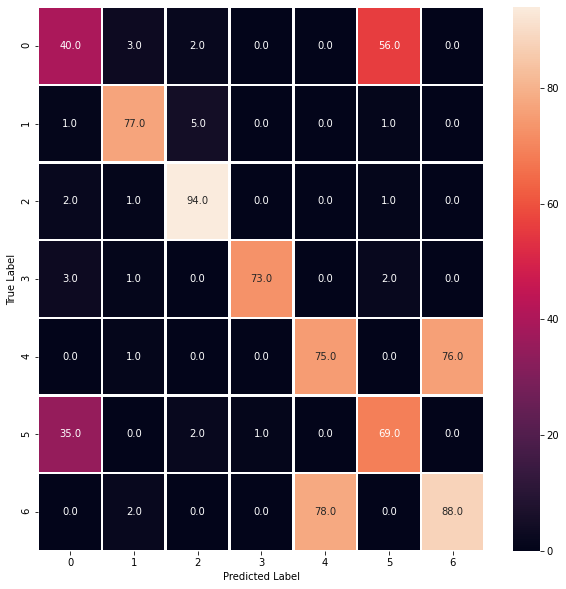

Making n-grams at 0m 0s .. of size:  8
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  8
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 70.26239013671875%


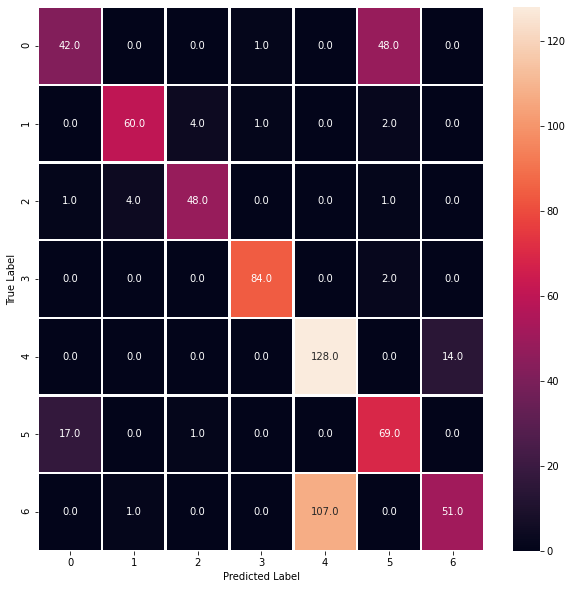

Making n-grams at 0m 0s .. of size:  7
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  7
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Accuracy is 67.76860046386719%


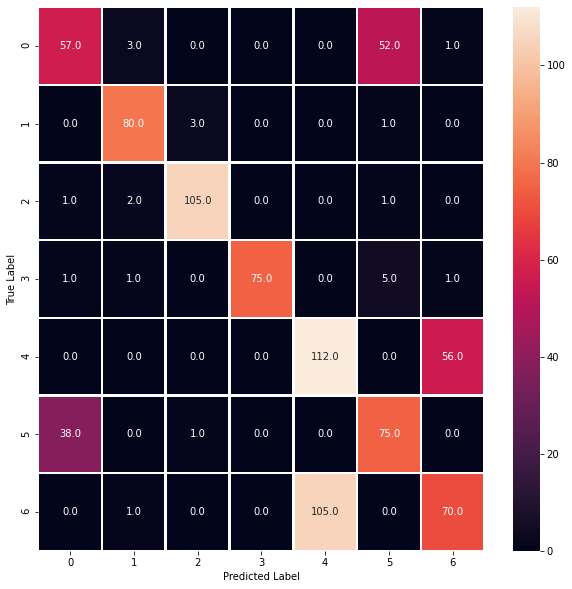

Making n-grams at 0m 0s .. of size:  8
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  8
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 67.31301879882812%


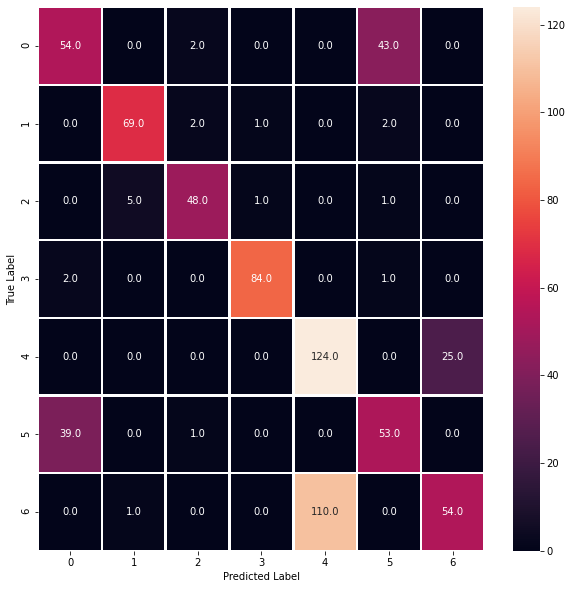

Making n-grams at 0m 0s .. of size:  7
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  7
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.44025421142578%


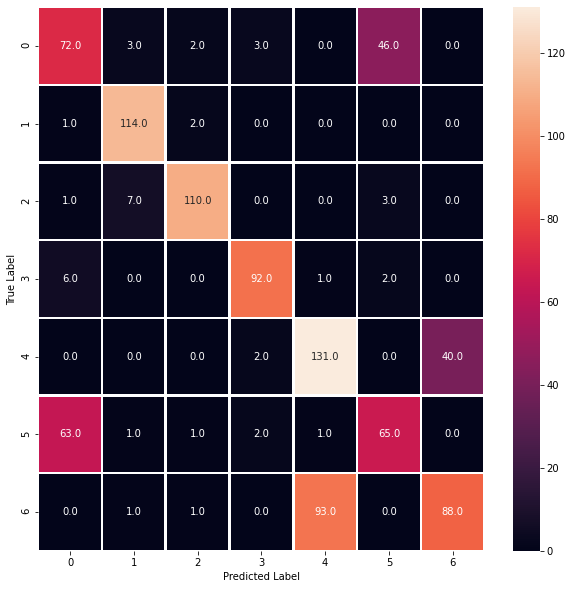

Making n-grams at 0m 0s .. of size:  8
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 6s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  8
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 7s
Accuracy is 70.33792114257812%


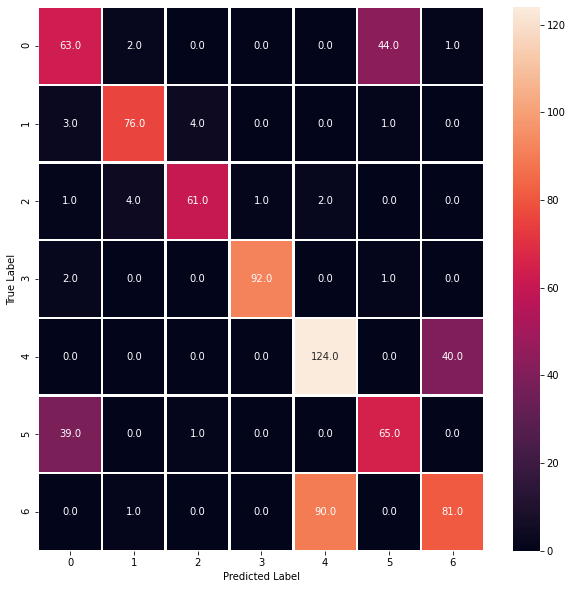

Making n-grams at 0m 0s .. of size:  7
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  7
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Accuracy is 61.85185241699219%


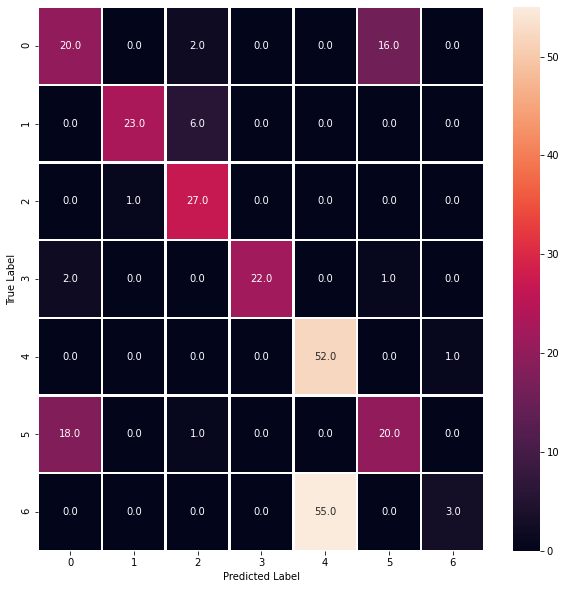

Making n-grams at 0m 0s .. of size:  8
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  8
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Accuracy is 59.288536071777344%


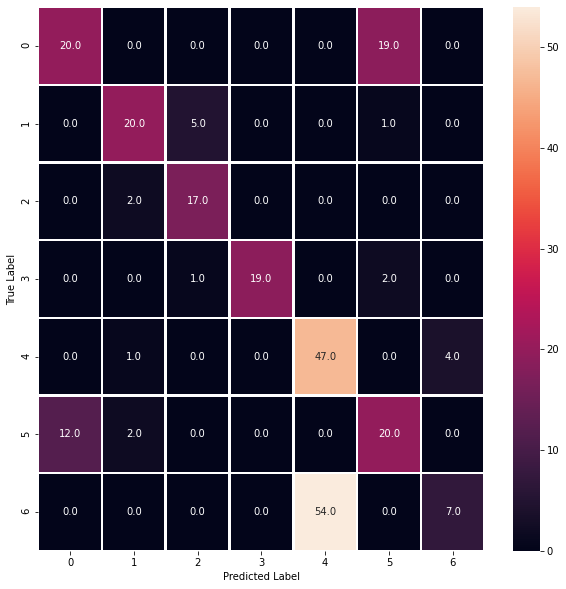

Making n-grams at 0m 0s .. of size:  7
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  7
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Accuracy is 63.5761604309082%


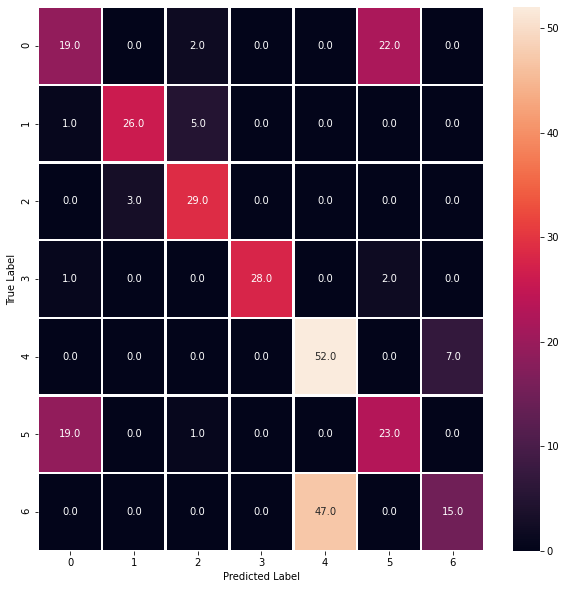

Making n-grams at 0m 0s .. of size:  8
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  8
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Accuracy is 62.86764907836914%


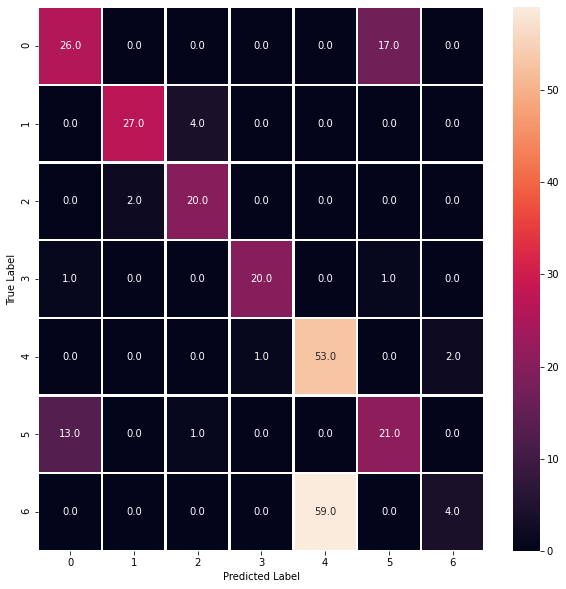

Making n-grams at 0m 0s .. of size:  7
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  7
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Accuracy is 64.13374328613281%


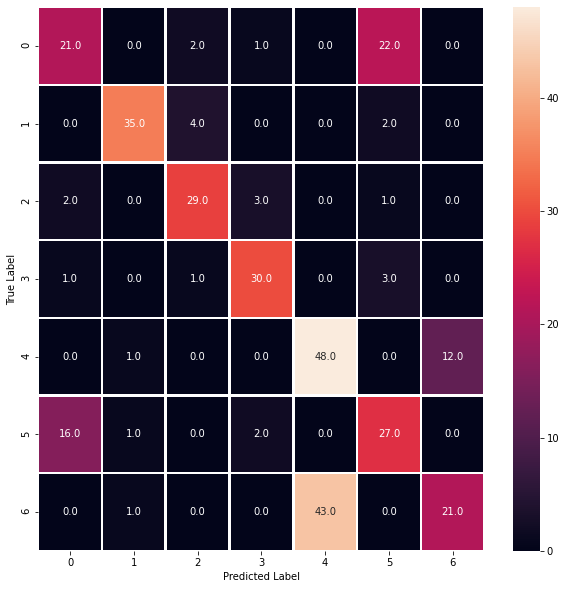

Making n-grams at 0m 0s .. of size:  8
Extracting features at 0m 0s ...
Preparing encoding at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Training Phase..
Training Complete.
Making n-grams for Test Data at 0m 0s .. of size:  8
Preparing encoding for Test Data at 0m 0s
Creating Encoding for X
Creating Encoding for Y
Encoding completed at 0m 2s
Accuracy is 59.27151870727539%


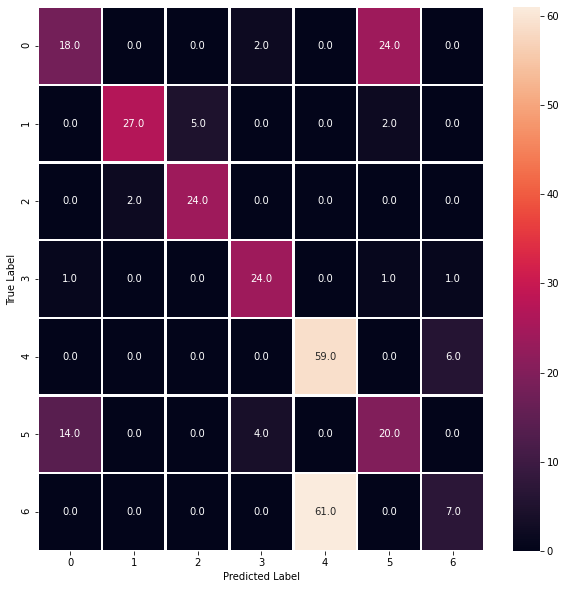

In [54]:
# Single NGRAM as Feature
n_gram_list = [7, 8]
n_instances = [200, 75]
n_features = [7, 10, 15]
acuuracy_list = []
loss_list = []

hidden_list = [32, 64, 128, 256]
n_layers_list = [1, 2, 3, 4]
embedding_list = [32, 64, 128, 256]
lr_list = [0.001, 0.005, 0.01, 0.05, 0.1,0.5]
epoch_list = [100, 500, 1000, 3000, 5000]

X_Train, Y_Train = preprocess(X_train[:-1], Y_train[:-1])
X_Test, Y_Test = preprocess(X_test[:-1], Y_test[:-1])
models = []
all_losses = []
all_accuracies = []

for n_instance in n_instances:
    for n_feature in n_features:
        for n_gram_size in n_gram_list:
            start = time.time()
            vocab, inp, target = prepare_data(X_Train, Y_Train, n_instance, n_gram_size, n_feature, dsl_groups_ABC)
            print('Training Phase..')
            hidden_size = 32
            input_size = len(vocab) # Number of grams in vocabulary
            n_layers = 1 # Number of layers of RNN
            embedding_size = 32
            lr = 0.001
            batch = 32
            n_epochs = 1000
            model, losses = start_training(inp, target, input_size, hidden_size, n_layers, embedding_size, lr, batch, n_epochs)
            models.append(model)
            all_losses.append(losses)

            x_test, y_test = get_data_chunk(X_Test, Y_Test, n_instance, dsl_groups_ABC)
            all_accuracies.append(test_model(model, x_test, y_test, n_gram_size, vocab))